In [1]:
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import copy

import dijkstra as dijk
import stacked_graph as sg
import testing as test
import graph_visualization as gv

# 1

In [2]:

# read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/gpt2_graph.json'
# # read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/bert-base-uncased_graph.json'
# # read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph.json'
# # read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph_NoFusion.json'
# with open(read_json_path)  as json_file:
#     raw_json = json.load(json_file) # returns json file as dict

# graph = sg.StackedGraph(raw_json=raw_json)

# subgraphs = list(dijk.graph_partition(graph))
# dijk.select_nodes(graph, subgraphs)


In [3]:
# groups = list(graph.get_node_groups(ASAP = False))
# print(test.group_validate(graph, groups))
# for group in groups:
#     print(group)


In [4]:
# n_graphs = len(groups)
# n_cols = 6  # Number of columns for the grid
# n_rows = (n_graphs + n_cols - 1) // n_cols  # Calculate the number of rows needed

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
# axes = axes.flatten()  # Flatten the array of axes


# for i in range(len(groups)):
#     if i >= 0:
#         test_group = groups[i]

#         start_stack = sg.StackedNode(0, [], [[]], [[]], opp='start', func_stack=['start'], cost_stack=[0])
#         first_stack = copy.deepcopy(graph.stack_list[graph.id_to_idx[test_group[0]]])
#         first_stack.parents = [0]

#         subgraph_stack_list = [start_stack, first_stack]
#         for stack_id in test_group[1:]:
#             stack = graph.stack_list[graph.id_to_idx[stack_id]]
#             new_node = copy.deepcopy(stack)
#             new_node.parents = set(new_node.parents) - graph.load_nodes
#             subgraph_stack_list.append(new_node)


#         new_graph = sg.StackedGraph(stack_list=subgraph_stack_list)
#         # gv.adj_to_graph(new_graph.adj_matrix, save=False, layout = 'spectral')
#         # gv.adj_to_graph(new_graph, save=False, layout = 'kk', title = f'Subgraph {i}')
#         gv.adj_to_graph(new_graph, ax=axes[i], layout='kk', title=f'Subgraph {i+1}')


# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])


# plt.tight_layout()
# plt.show()


# 2 Graph Visualization

In [5]:
subgraph_to_plot = 1


read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/gpt2_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/bert-base-uncased_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph_NoFusion.json'
with open(read_json_path)  as json_file:
    raw_json = json.load(json_file) # returns json file as dict
graph = sg.StackedGraph(raw_json=raw_json)


subgraphs = list(dijk.graph_partition(graph))
dijk.select_nodes(graph, subgraphs)

In [6]:
def draw_subgraphs(graph, sub=0):
    subgraphs = list(dijk.graph_partition(graph))
    dijk.select_nodes(graph, subgraphs)

    if sub == 'all':
        n_graphs = len(subgraphs)
        n_cols = 6  # Number of columns for the grid
        n_rows = (n_graphs + n_cols - 1) // n_cols  # Calculate the number of rows needed

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
        axes = axes.flatten()  # Flatten the array of axes

        for i in range(len(subgraphs)):
            gv.adj_to_graph(subgraphs[i], ax=axes[i], layout='kk', title=f'Subgraph {i+1}')

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

    else:
        fig, ax = plt.subplots(figsize=(6, 6))
        gv.adj_to_graph(subgraphs[sub], ax=ax, layout='kk', title=f'Subgraph {sub}')


    plt.tight_layout()
    plt.show()

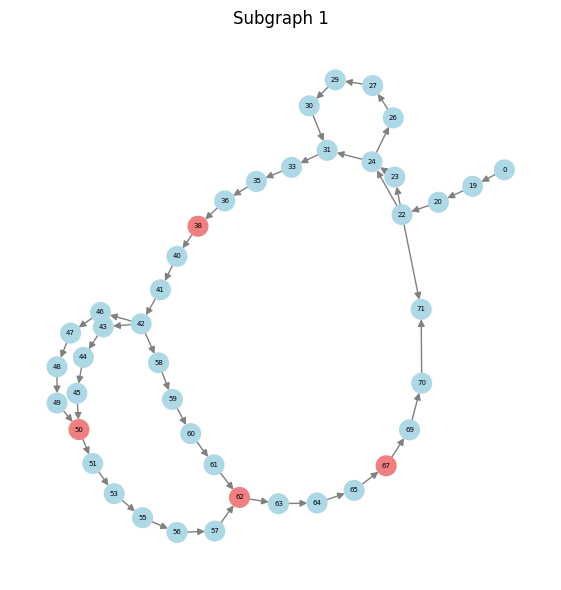

In [7]:
# draw_subgraphs(graph)
# draw_subgraphs(graph)
draw_subgraphs(graph, sub=subgraph_to_plot)
# draw_subgraphs(graph, sub='all')

# 3 Timeline Visualization

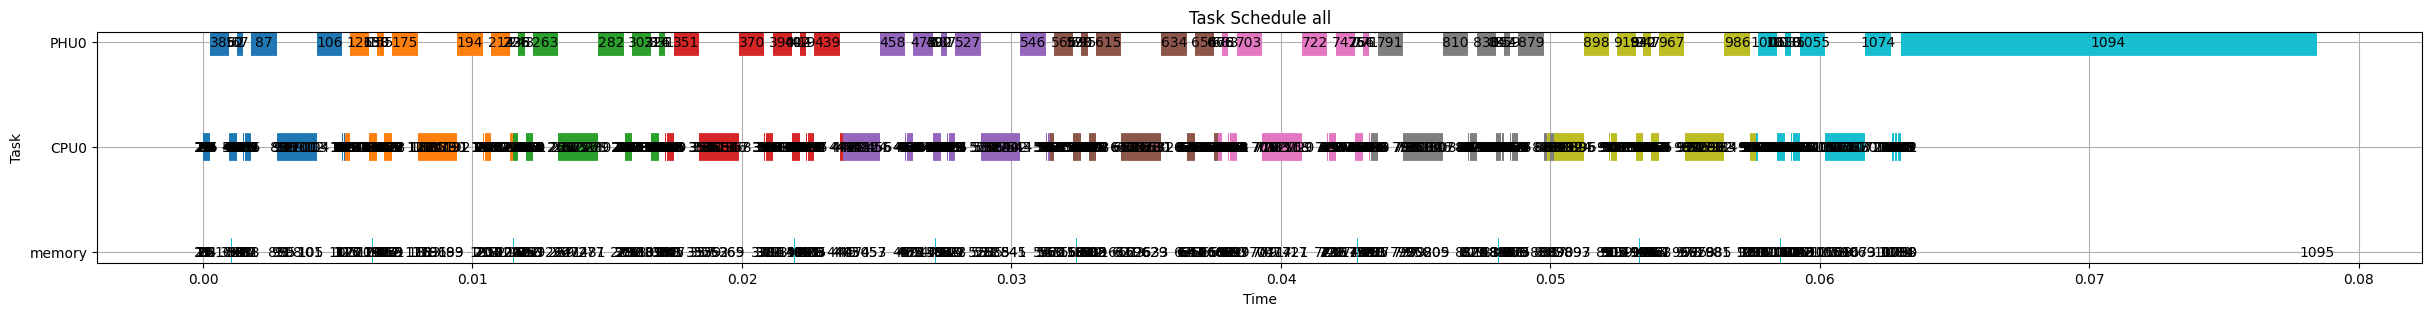

end_time=np.float64(0.07842977520000002)


In [8]:
read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/gpt2_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/bert-base-uncased_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph_NoFusion.json'
with open(read_json_path)  as json_file:
    raw_json = json.load(json_file) # returns json file as dict


graph = sg.StackedGraph(raw_json=raw_json)
# gv.adj_to_graph(graph.adj_matrix, save=True, layout = 'spectral')
subgraphs = list(dijk.graph_partition(graph))

dijk.select_nodes(graph, subgraphs)
end_time, break_points = dijk.schdeule_nodes(graph, subgraphs)
break_points.sort()
gv.make_schedule_diagram(graph, xlim_start=None, xlim_end=None)
# gv.make_schedule_diagram(graph, xlim_start=0, xlim_end=0.1)

# # PLOT EACH SUBSECTION
# for i in range(len(break_points)-1):
#     print(f'{break_points[i]} - {break_points[i+1]}')
#     gv.make_schedule_diagram(graph, xlim_start=break_points[i], xlim_end=break_points[i+1])


print(f'{end_time=}')
# make_schedule_diagram(graph, xlim_start=0, xlim_end=0.01)


# 4 Memory Visualization

In [9]:
read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/gpt2_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/model_to_graph/bert-base-uncased_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph.json'
# read_json_path = '/home/rjtomich/photonic_compiler/Pytorch-LeNet/simple_LeNet_graph_NoFusion.json'
with open(read_json_path)  as json_file:
    raw_json = json.load(json_file) # returns json file as dict


graph = sg.StackedGraph(raw_json=raw_json)
# gv.adj_to_graph(graph.adj_matrix, save=True, layout = 'spectral')
subgraphs = list(dijk.graph_partition(graph))

dijk.select_nodes(graph, subgraphs)
end_time, break_points = dijk.schdeule_nodes(graph, subgraphs)
break_points.sort()
print(f'{end_time=}')
schedule_data = graph.create_schedule_data()
dram, sram = dijk.get_memory_profile(graph, schedule_data)

end_time=np.float64(0.07842977520000002)
dram_total=237892
sram_total=0


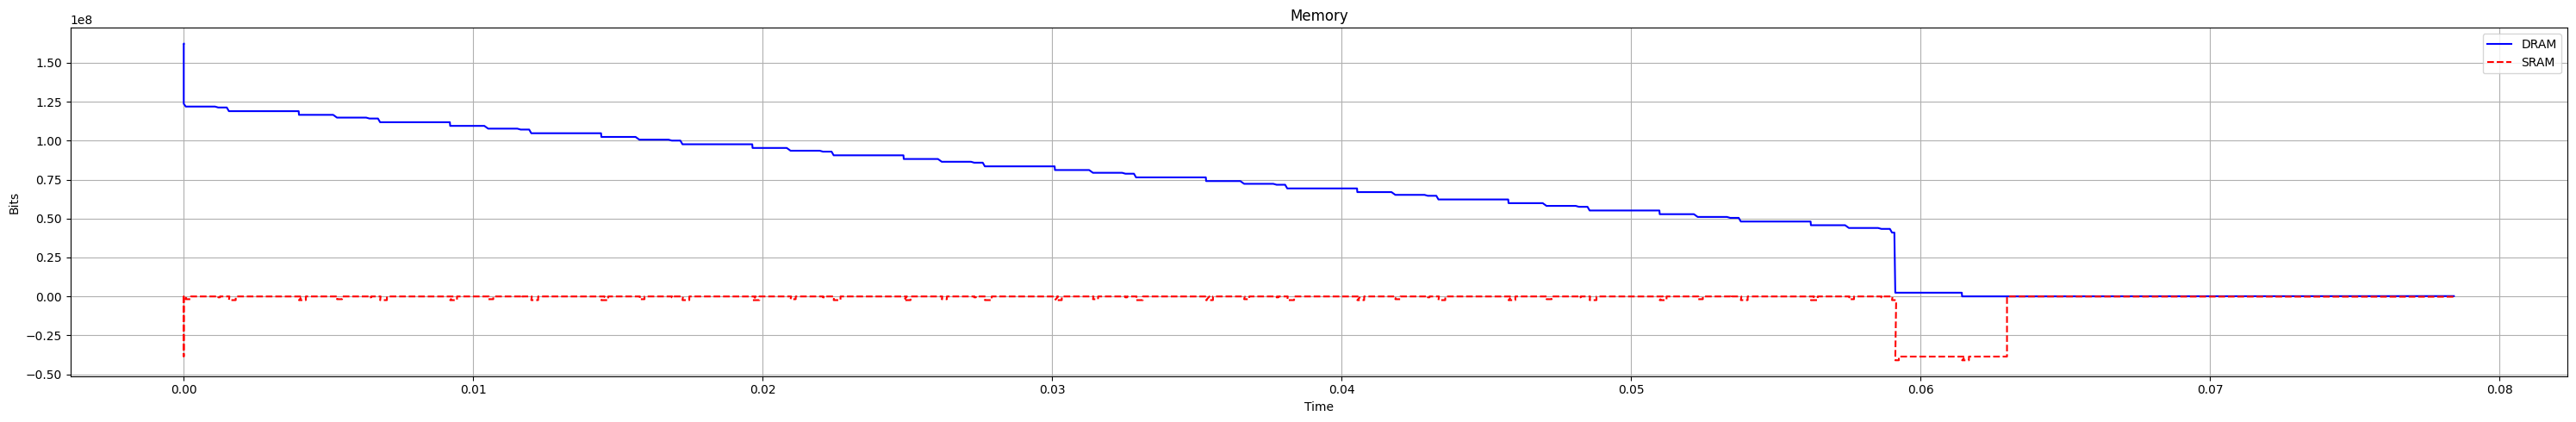

In [10]:
dram_t, dram_v = zip(*dram)
sram_t, sram_v = zip(*sram)

sram_v = [-v for v in sram_v]


plt.figure(figsize=(30, 5))  # Optional: Adjust figure size

plt.plot(dram_t, dram_v, linestyle='-', color='b', label='DRAM')
plt.plot(sram_t, sram_v, linestyle='--', color='r', label='SRAM')

plt.xlabel('Time')
plt.ylabel('Bits')
plt.title('Memory')
plt.legend()


plt.grid(True)
plt.tight_layout()

plt.show()